In [79]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from training import train
from models import *
from A2C_agent import *
from helpers import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# VANILLA A2C IMPLEMENTATION 

seed = 70 reaches 200 avg rew

In [80]:
# device = device_selection() # mps -> cuda -> cpu
device = "cpu"
print(device)

seed = 70
set_seed(seed)

# Initialize environment
env = gym.make('CartPole-v1')

# hyperparameters
gamma_ = 0.99
lr_actor = 1e-5
lr_critic = 1e-3
eps = 0.1
batch_len = 32
num_episodes = 50000
total_steps_budget = 500000
max_steps_per_episode = 1000

# neural network structure
input_size = env.observation_space.shape[0] # 4
hidden_size = 64
output_size_actor = env.action_space.n # 2
output_size_critic = 1


# Initialize agent 
agent = Agent(input_size, hidden_size, \
                output_size_actor, output_size_critic, \
                eps, gamma_, lr_actor, lr_critic, \
                device=device)
actor_optimizer = torch.optim.Adam(agent.actor.parameters(), agent.lr_actor)
critic_optimizer = torch.optim.Adam(agent.critic.parameters(), agent.lr_critic)

# Initialize batch
critic_losses = []
actor_losses = []
episode_rewards = []
evaluation_results = []

train_budget_reached = False

for episode in range(num_episodes):
    reset_seed = np.random.randint(0, 1000000) # Random seed for resetting the environment, fixed sequence because of set_seed() call above
    state, _ = env.reset(seed=reset_seed)
    state = tensor(state).to(device)  # Convert state to a tensor
    episode_reward = 0

    for t in range(max_steps_per_episode):

        action = agent.select_action(state, policy="eps-greedy")
        next_state, reward, terminated, truncated, _ = env.step(action.detach().item())
        agent.num_steps += 1
        next_state = tensor(next_state).to(device)  # Convert next_state to a tensor
        done = terminated or truncated
        episode_reward += reward

        # Add the experience to the batch
        experience = (state, action, reward, next_state, terminated)

        # Train the agent
        actor_loss, critic_loss = train(agent, actor_optimizer, critic_optimizer, experience)
        critic_losses.append(critic_loss)
        actor_losses.append(actor_loss)

        state = next_state

        if agent.num_steps % 20000 == 0: 
            print("---- Proceeding to evaluate model ... ----")
            mean_reward, std_reward, value_trajectories = agent.evaluate_agent(num_episodes=10)
            evaluation_results.append((mean_reward,std_reward))
            print(f"Mean reward: {mean_reward:.2f}, Std reward: {std_reward:.2f}")
            print("----     Evaluation finished        ----")
        if (agent.num_steps >= total_steps_budget): 
            train_budget_reached = True
            break
        if done: break

    episode_rewards.append(episode_reward)
    if episode % 100 == 0:
        print(f"Episode {episode} finished after {t+1} steps with reward {episode_reward}")
        print(f"Actor loss: {actor_losses[-1]:.4f}, Critic loss: {critic_losses[-1]:.4f}")
        print(f"Total steps taken during training: {agent.num_steps}")
    if (train_budget_reached): 
            print(f"Reached total training budget of {total_steps_budget} steps ----> Stopping training at episode {episode}")
            break



cpu
Episode 0 finished after 13 steps with reward 13.0
Actor loss: 0.9693, Critic loss: 0.9831
Total steps taken during training: 13
Episode 100 finished after 25 steps with reward 25.0
Actor loss: 0.5742, Critic loss: 0.4299
Total steps taken during training: 1710
Episode 200 finished after 17 steps with reward 17.0
Actor loss: -0.1197, Critic loss: 0.0169
Total steps taken during training: 3923
Episode 300 finished after 40 steps with reward 40.0
Actor loss: 0.1466, Critic loss: 0.0319
Total steps taken during training: 6424
Episode 400 finished after 33 steps with reward 33.0
Actor loss: -1.3763, Critic loss: 2.6761
Total steps taken during training: 10686
Episode 500 finished after 40 steps with reward 40.0
Actor loss: 0.0695, Critic loss: 0.0293
Total steps taken during training: 15455
---- Proceeding to evaluate model ... ----
Mean reward: 75.70, Std reward: 30.06
----     Evaluation finished        ----
Episode 600 finished after 119 steps with reward 119.0
Actor loss: 0.0099, C

workers all use the same parameters and get updated with the same gradient at the same time (if not at the same time --> updates with different policies by definition, but A2C is on-policy). Doesn't matter if they (inevitably) end episodes at different time-steps. What matters is they have the same policy when accumulating a batch (same actor-critic params).

batches vanilla are (1x1), in general (num_time_steps x num_workers)

In [91]:
# Initialize batch
episode_rewards_test = []
num_episodes_test = 100

for episode in range(num_episodes_test):
    state, _ = env.reset()
    state = tensor(state).to(device)  # Convert state to a tensor

    episode_reward = 0

    for t in range(max_steps_per_episode):
        action = agent.select_action(state, policy="greedy")
        next_state, reward, terminated, truncated, _ = env.step(action.item())
        agent.num_steps += 1
        
        next_state = tensor(next_state).to(device)  # Convert next_state to a tensor
        done = terminated or truncated
        episode_reward += reward
        
        state = next_state
        if done: break
    episode_rewards_test.append(episode_reward)
    print(f"Episode {episode} finished after {t+1} steps with reward {episode_reward:.2f}")

print(f"Average reward over {num_episodes_test} episodes: {np.mean(episode_rewards_test):.2f}")


Episode 0 finished after 190 steps with reward 190.00
Episode 1 finished after 224 steps with reward 224.00
Episode 2 finished after 151 steps with reward 151.00
Episode 3 finished after 246 steps with reward 246.00
Episode 4 finished after 195 steps with reward 195.00
Episode 5 finished after 152 steps with reward 152.00
Episode 6 finished after 132 steps with reward 132.00
Episode 7 finished after 182 steps with reward 182.00
Episode 8 finished after 145 steps with reward 145.00
Episode 9 finished after 231 steps with reward 231.00
Episode 10 finished after 185 steps with reward 185.00
Episode 11 finished after 144 steps with reward 144.00
Episode 12 finished after 140 steps with reward 140.00
Episode 13 finished after 235 steps with reward 235.00
Episode 14 finished after 140 steps with reward 140.00
Episode 15 finished after 136 steps with reward 136.00
Episode 16 finished after 177 steps with reward 177.00
Episode 17 finished after 240 steps with reward 240.00
Episode 18 finished 

In [89]:
len(episode_rewards)

3693

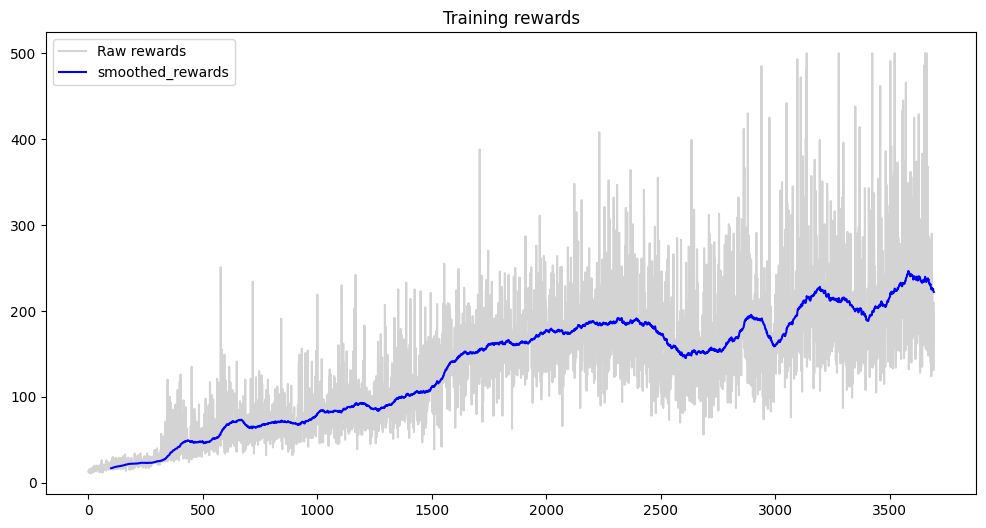

In [82]:
# Convert the list to a pandas DataFrame
episode_rewards_df = pd.DataFrame(episode_rewards, columns=['reward'])

# Compute a rolling window of size 10
episode_rewards_df['smoothed_rewards'] = episode_rewards_df['reward'].rolling(window=100).mean()

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(episode_rewards_df['reward'], label='Raw rewards', color='lightgray')
plt.plot(episode_rewards_df['smoothed_rewards'], label='smoothed_rewards', color='blue')
plt.title('Training rewards')
# plt.xscale('log')
plt.legend()
plt.show()

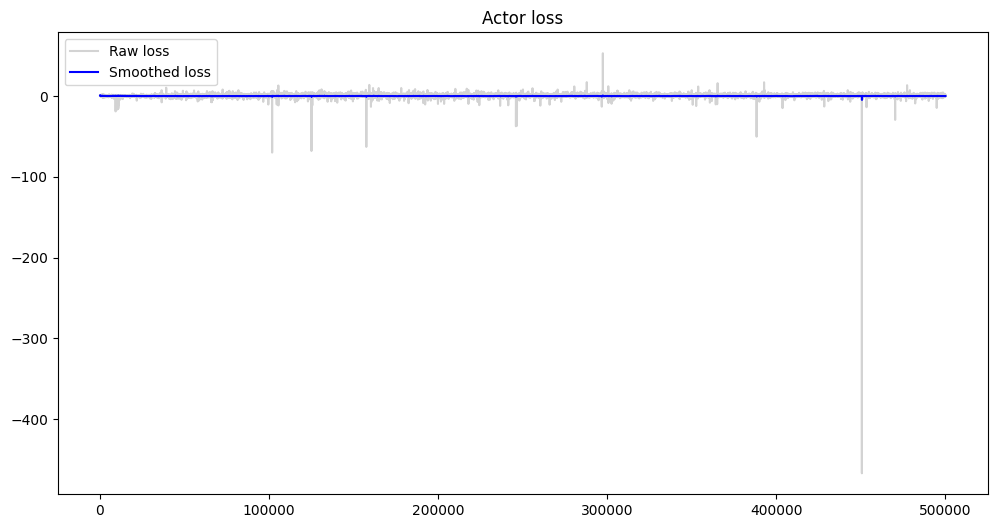

In [83]:
# Convert the list to a pandas DataFrame
actor_losses_df = pd.DataFrame(actor_losses, columns=['loss'])

# Compute a rolling window of size 10
actor_losses_df['smoothed_loss'] = actor_losses_df['loss'].rolling(window=100).mean()

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(actor_losses_df['loss'], label='Raw loss', color='lightgray')
plt.plot(actor_losses_df['smoothed_loss'], label='Smoothed loss', color='blue')
plt.legend()
plt.title('Actor loss')
plt.show()

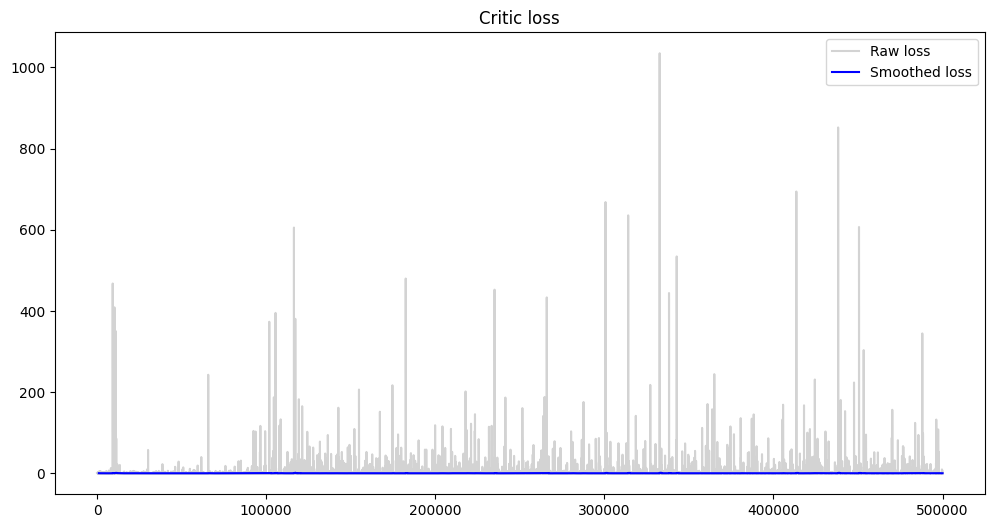

In [88]:
# Convert the list to a pandas DataFrame
critic_losses_df = pd.DataFrame(critic_losses, columns=['loss'])

# Compute a rolling window of size 10
critic_losses_df['smoothed_loss'] = critic_losses_df['loss'].rolling(window=1000).mean()

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(critic_losses_df['loss'], label='Raw loss', color='lightgray')
plt.plot(critic_losses_df['smoothed_loss'], label='Smoothed loss', color='blue')
# plt.ylim([0,0.5])
plt.legend()
plt.title('Critic loss')
plt.show()

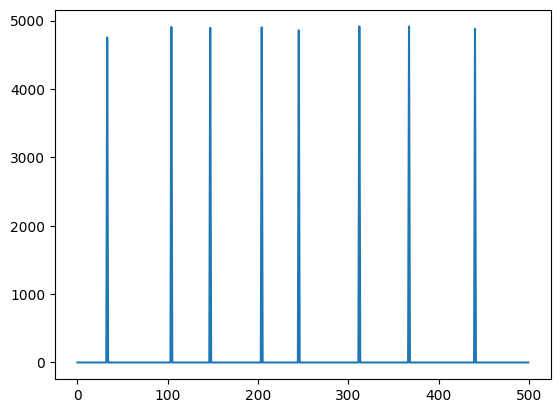

In [53]:
plt.plot(critic_losses[45000:45500])